In [1]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
import json
from IPython.display import display, Image
from specutils import Spectrum1D
from astropy import units
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from astropy.time import Time
from Supernovae import *

# iPTF16hvw Spectral Analysis


In [3]:
#Read In spectral data

#11/07/2016
spectrum1 = ascii.read('../Data/16hvw_spectra/16hvw_20161107_Gemini_N_v4.ascii')

#11/09/2016
spectrum2 = ascii.read('../Data/16hvw_spectra/16hvw_20161109_P60_v1.ascii')

#11/28/2016
spectrum3 = ascii.read('../Data/16hvw_spectra/16hvw_20161128_NOT_v1.ascii')

#12/06/2016
spectrum4 = ascii.read('../Data/16hvw_spectra/16hvw_20161206_NOT_v1.ascii')

#redshift of SN iPTF 16hvw
z_16hvw = .03663

#MJD date for maximum brightness iPTF16hvw
MJD_max_16hvw = 57714.40
type(spectrum1)

astropy.table.table.Table

In [4]:
#Create Supernovae object for iPTF16hvw
iPTF16hvw = Supernovae("iPTF16hvw" , z_16hvw, MJD_max_16hvw)


#Create Spectra objects - includes correcting flux for redshift, normalizing, and shifting wavelength to restframe
Spec_16hvw1 = Spectra(spectrum1, convert_date_toMJD('2016-11-7'), z_16hvw, MJD_max_16hvw,  )
Spec_16hvw2 = Spectra(spectrum2, convert_date_toMJD('2016-11-9'), z_16hvw, MJD_max_16hvw,  )
Spec_16hvw3 = Spectra(spectrum3, convert_date_toMJD('2016-11-28'), z_16hvw, MJD_max_16hvw,  )
Spec_16hvw4 = Spectra(spectrum4,convert_date_toMJD('2016-12-6'), z_16hvw, MJD_max_16hvw,  )

#Store Spectra objects in corresponding supernovae

iPTF16hvw.store_spectra(Spec_16hvw1)
iPTF16hvw.store_spectra(Spec_16hvw2)
iPTF16hvw.store_spectra(Spec_16hvw3)
iPTF16hvw.store_spectra(Spec_16hvw4)

### Plotting Spectra 


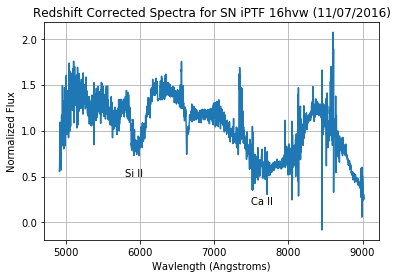

In [5]:
#Create plot of 16hvw spectra (-16.5 days)
hvw1_wavelength = iPTF16hvw.spectra[0].data['Wavelength']
hvw1_flux = iPTF16hvw.spectra[0].data['Flux']


plt.plot(hvw1_wavelength, hvw1_flux)
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (11/07/2016)')
plt.ylabel('Normalized Flux')
plt.grid()

#Add text indicating Absorption lines
plt.text(5800, .5, "Si II")
plt.text(7500,.20, "Ca II")


#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161107_spectra')
plt.show()


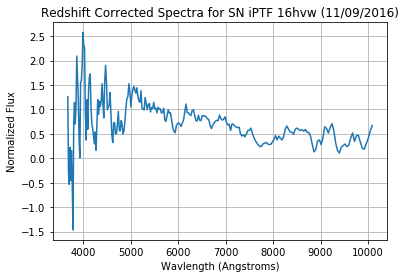

In [6]:
#Create plot of 16hvw spectra (-14.5 days)
hvw2_wavelength = iPTF16hvw.spectra[1].data['Wavelength']
hvw2_flux = iPTF16hvw.spectra[1].data['Flux']

plt.plot(hvw2_wavelength, hvw2_flux)
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (11/09/2016)')
plt.ylabel('Normalized Flux')

plt.grid()

#Add text indicating Absorption lines

'''
plt.text(6000, 0e-16, "Si II")
plt.text(7900, -.2e-16, "Ca II")
plt.text(4700,-.1e-16,"Fe II")
plt.text(5600, 3e-16,"S II")
plt.text(3800, -1.9e-16, "Ca II")
plt.text(4200, 2.1e-16, "Fe II")
'''

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161109_spectra')
plt.show()


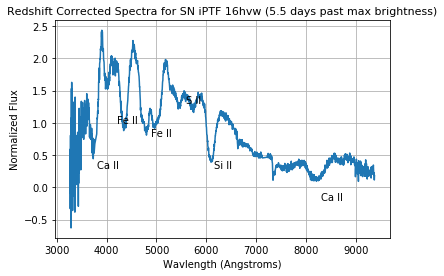

In [7]:
#Create plot of 16hvw spectra (+5.5 days)
hvw3_wavelength = iPTF16hvw.spectra[2].data['Wavelength']
hvw3_flux = iPTF16hvw.spectra[2].data['Flux']

plt.plot(hvw3_wavelength, hvw3_flux)
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (5.5 days past max brightness)', fontsize=11)
plt.ylabel('Normalized Flux')

plt.grid()

#Add text indicating Absorption lines
plt.text(6150, .3, "Si II")
plt.text(8300, -0.2, "Ca II")
plt.text(4900, .8,"Fe II")
plt.text(5600, 1.3,"S II")
plt.text(3800, .3, "Ca II")
plt.text(4200, 1, "Fe II")

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161128_spectra')
plt.show()

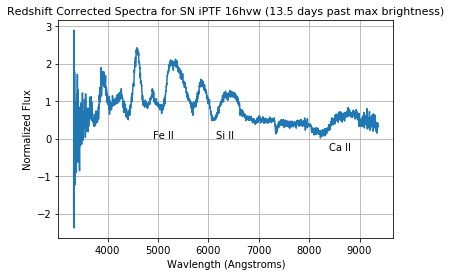

In [8]:
#Create plot of 16hvw spectra (+13.5 days)
hvw4_wavelength = iPTF16hvw.spectra[3].data['Wavelength']
hvw4_flux = iPTF16hvw.spectra[3].data['Flux']

plt.plot(hvw4_wavelength, hvw4_flux)
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (13.5 days past max brightness)', fontsize=11)
plt.ylabel('Normalized Flux')


plt.grid()

#Add text indicating Absorption lines
plt.text(6150, .2e-16, "Si II")
plt.text(8400, -.3, "Ca II")
plt.text(4900, .6e-16,"Fe II")
#plt.text(5600, 3e-16,"S II")
#plt.text(3800, .8e-16, "Ca II")
#plt.text(4200, 2.1e-16, "Fe II")

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161206_spectra')
plt.show()

### Estimate Absorption Velocities



In [9]:
#Estimate absorption velocities 

#store restframe wavelengths of absorption in Angstroms
SiII_restframe = 6355

#Ca II is a triplet - used the average wavelength 
CaII_restframe = (8498 + 8542 + 8662) / float(3)

#speed of light (km/s)
c = 3e5 

#store absorption minimum wavelength for Si II, Ca II lines; estimated minimum from pandas dataframe
#Divided by 1+z to convert doppler shifted wavelengths to the SN restframe 


SiII_absorption_minimum_1 = 6203 / (1 + z_16hvw)
CaII_absorption_minimum_1 = 7996 / (1 + z_16hvw)


SiII_absorption_minimum_2 = 6152 / (1 + z_16hvw)
CaII_absorption_minimum_2 = 8004 / (1 + z_16hvw)


SiII_absorption_minimum_3 = 6317 / (1 + z_16hvw)
CaII_absorption_minimum_3 = 8505 / (1 + z_16hvw)


SiII_absorption_minimum_4 = 6322 / (1 + z_16hvw)
CaII_absorption_minimum_4 = 8561 / (1 + z_16hvw)

In [10]:
#Calculate SiII absorption velocities (km/s)
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_1))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_2))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_3))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_4))

17522.599577173427
19845.08021905059
12331.17226003619
12103.478079459965


In [11]:
#Calculate CaII absorption velocities (km/s)
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_1))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_2))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_3))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_4))

29899.98861356777
29629.75348461687
12706.2785340663
10814.632631409906


# SN2011fe Spectral Analysis

In [12]:
#MJD date for maximum brightness SN2011fe
MJD_max_2011fe = 55814

#MJD date for iPTF16hvw spectra of interest
#11/28/16
date1 = 57720

#12/06/16
date2 = 57728

#Redshift of 2011fe gathered from OSN
z_2011fe = 0.000804

#MJD days past maximum 

#phase of iPTF16hvw 11/28/16 spectra
dpm1 = date1 - MJD_max_16hvw

#phase of iPTF16hvw 12/06/16 spectra
dpm2 = date2 - MJD_max_16hvw

In [13]:
#Grab 2011fe spectra with phases near 5.6 days past maximum
SN2011fe = create_SN_object('SN2011fe.json', MJD_max_2011fe, z_2011fe)


In [14]:
#Run loop for a cursory look at 2011fe spectra phases
#for i in range(len(SN2011fe.spectra)):
 #   print(i, SN2011fe.spectra[i].phase)

In [15]:
Comp_2011fe1 = SN2011fe.find_spectra(4)
Comp_2011fe2 = SN2011fe.find_spectra(13.6)


# Comparing iPTF16hvw and SN2011fe

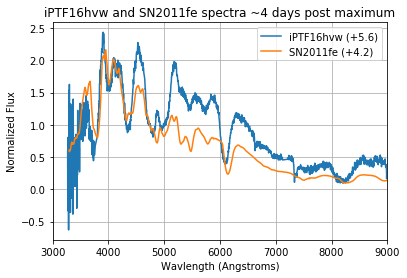

In [16]:
#Plot iPTF16hvw spectra
f, ax = plt.subplots()
plt.plot(hvw3_wavelength, hvw3_flux, label='iPTF16hvw (+5.6)')


#plot SN2011fe spectra 
plt.plot(Comp_2011fe1.data['Wavelength'], Comp_2011fe1.data['Flux'], label='SN2011fe (+4.2)')
plt.grid()


plt.legend()

plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2011fe spectra ~4 days post maximum')
plt.ylabel('Normalized Flux')
plt.xlim([3000, 9000])

plt.savefig('../Images/2011fe_vs_16hvw//2011fe_comparison_spectra_4days')

plt.show()

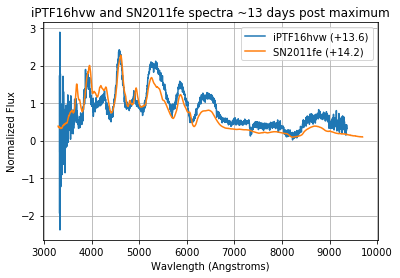

In [17]:
#Plot iPTF16hvw spectra

f2, ax2 = plt.subplots()
plt.plot(hvw4_wavelength ,hvw4_flux, label='iPTF16hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2011fe spectra ~13 days post maximum')
plt.ylabel('Normalized Flux')


#plot SN2011fe spectra 
plt.plot(Comp_2011fe2.data['Wavelength'], Comp_2011fe2.data['Flux'], label='SN2011fe (+14.2)')
plt.legend()
plt.savefig('../Images/2011fe_vs_16hvw//2011fe_comparison_spectra_12days')
plt.grid()
plt.show()

#  SN2002dj Spectral Analysis

In [18]:
#Store 2002dj B band maximum date
MJD_max_2002dj = 52450

#store 2002dj redshift
z_2002dj = 0.009393



In [19]:
#Grab 2002dj spectra with phases near 5.6 days past maximum
SN2002dj = create_SN_object('SN2002dj.json', MJD_max_2002dj, z_2002dj)


In [20]:
#Create 2002dj comparison spectral objects 
Comp_2002dj1 = SN2002dj.find_spectra(5.6)
Comp_2002dj2 = SN2002dj.find_spectra(13.6)

In [21]:
Comp_2002dj2.phase

12.0

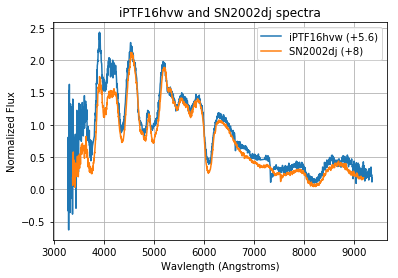

In [22]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(hvw3_wavelength, hvw3_flux, label='iPTF16hvw (+5.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002dj spectra')
plt.ylabel('Normalized Flux')


#plot SN2002dj spectra 
plt.plot(Comp_2002dj1.data['Wavelength'], Comp_2002dj1.data['Flux'], label='SN2002dj (+8)')
plt.legend()
plt.savefig('../Images/2002dj_vs_16hvw/2002dj_comparison_spectra_8days')
plt.grid()
plt.show()

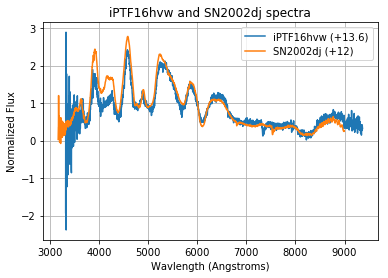

In [23]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(hvw4_wavelength, hvw4_flux, label='iPTF16hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002dj spectra')
plt.ylabel('Normalized Flux')


#plot SN2002dj spectra 

plt.plot(Comp_2002dj2.data['Wavelength'], Comp_2002dj2.data['Flux'], label='SN2002dj (+12)')
plt.legend()
plt.savefig('../Images/2002dj_vs_16hvw/2002dj_comparison_spectra_16days')
plt.grid()
plt.show()

# SN2002bo Spectral Analysis


In [24]:
#Store date of B bandmax brightness SN2002ob
MJD_max_2002bo = 52356  

#Store redshift of SN2002bo
z_2002bo = .0044

In [25]:
SN2002bo = create_SN_object('SN2002bo.json', MJD_max_2002bo, z_2002bo)

In [47]:
#Run loop to look at SN2002bo spectra of interest
#for i in range(len(SN2002bo.spectra)):
 #   print(i, SN2002bo.spectra[i].phase)

In [48]:
#Create 2002dj comparison spectral objects 
Comp_2002bo1 = SN2002bo.find_spectra(5.6)
Comp_2002bo2 = SN2002bo.find_spectra(13.6)


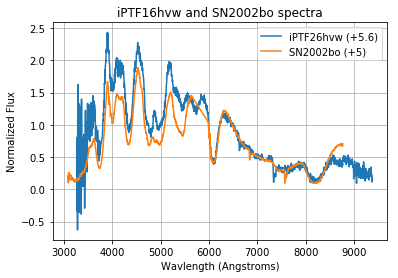

In [49]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(hvw3_wavelength, hvw3_flux, label='iPTF26hvw (+5.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002bo spectra')
plt.ylabel('Normalized Flux')


#plot SN2002bo spectra 
plt.plot(Comp_2002bo1.data['Wavelength'], Comp_2002bo1.data['Flux'], label='SN2002bo (+5)')
plt.legend()
plt.savefig('../Images/2002bo_vs_16hvw/2002bo_comparison_spectra_5days')
plt.grid()
plt.show()

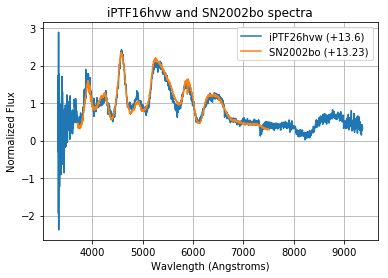

In [50]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(hvw4_wavelength, hvw4_flux, label='iPTF26hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002bo spectra')
plt.ylabel('Normalized Flux')


#plot SN2002bo spectra 
plt.plot(Comp_2002bo2.data['Wavelength'], Comp_2002bo2.data['Flux'], label='SN2002bo (+13.23)')
plt.legend()
plt.savefig('../Images/2002bo_vs_16hvw/2002bo_comparison_spectra_13days')
plt.grid()
plt.show()

# iPTF16hvw Equivalent Width and Absorption Velocity Measurements

In [51]:
#Define a gaussian profile function to fit to the absorption line data
def Gaussian_profile(w, a, b, c, d, e):
    return a + b*w + c*np.exp(-((w - d)**2)/ e)

#Define a function to trim spectral data to capture absorption line
def Trim(spectra, start, stop):
    '''
    spectra - Spectral object 
    start - starting wavelength
    stop - stop wavelength
    '''
    return spectra.data.drop(spectra.data[(spectra.data.Wavelength <start) | (spectra.data.Wavelength > stop)].index)
   
def Calc_EW(Absorption, *popt):
    '''
    Absorption - trimmed Spectra of absorption line
    *popt - best fit parameters for gaussian fit
    '''
    cont_int = np.max(Absorption['Flux'])
    return integrate.quad(lambda x: 1 - ((Gaussian_profile(x, *popt)/ cont_int)), np.min(Absorption['Wavelength']), np.max(Absorption['Wavelength']))
    
def Calc_Centroid(Absorption ,*popt):
    '''
    Absorption - trimmed Spectra of absorption line
    *popt - best fit parameters for gaussian fit
    '''
    
    def Gauss(w , c, d, e):
        return c*np.exp(-((w - d)**2)/ e)
    
    minim = np.min(Absorption['Wavelength'])
    maxim = np.max(Absorption['Wavelength']) 
    return integrate.quad(lambda x:  x * Gauss(x, *popt[2:5]), minim, maxim)[0] / integrate.quad(lambda x:  Gauss(x, *popt[2:5]), minim, maxim)[0]

    

### Si II 6355 EW measurement

In [52]:
#Trim data of iPTF16hvw near Si II 6355 absorption line

#11/07/2016 spectra
SiII_1_6355 = Trim(iPTF16hvw.spectra[0], 5750, 6250)

#11/28/16 spectra
SiII_3_6355 = Trim(iPTF16hvw.spectra[2], 5900, 6300)

#12/06/16 spectra
SiII_4_6355 = Trim(iPTF16hvw.spectra[3], 5900, 6350)


In [53]:
#Find the best fit parameters
popt1, pcov1 = curve_fit(Gaussian_profile, SiII_1_6355['Wavelength'], SiII_1_6355['Flux'], p0=[0, -2, 0, 5950, 1])
popt3, pcov3 = curve_fit(Gaussian_profile, SiII_3_6355['Wavelength'], SiII_3_6355['Flux'], p0=[0, -2, 0, 6100, 1])
popt4, cov4 = curve_fit(Gaussian_profile, SiII_4_6355['Wavelength'], SiII_4_6355['Flux'], p0=[0,-2,0,6100,1])




In [54]:
#Plot Fits
x1 = np.arange(5750, 6250, 1)
x3 = np.arange(5900, 6300, 1)
x4 = np.arange(5900, 6350,1)

y1 = Gaussian_profile(x1, *popt1)
y3 = Gaussian_profile(x3, *popt3)
y4 = Gaussian_profile(x4, *popt4)


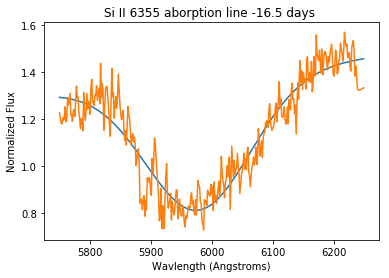

In [55]:
#Si II 6355 absorption line at -16.5 phase

plt.figure()
plt.plot(x1,y1)
plt.plot(SiII_1_6355['Wavelength'],SiII_1_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line -16.5 days ")
plt.show()

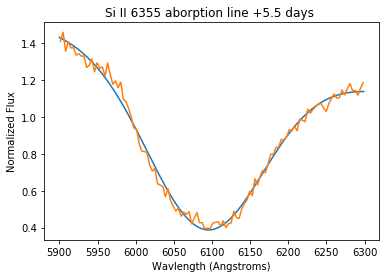

In [56]:
#Si II 6355 absorption line at +5.5 phase
plt.figure()
plt.plot(x3,y3)
plt.plot(SiII_3_6355['Wavelength'],SiII_3_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line +5.5 days ")
plt.show()

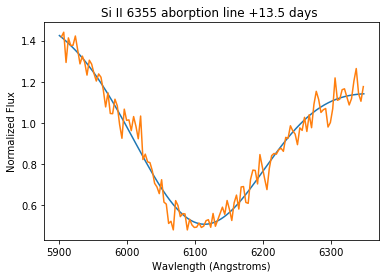

In [57]:
#Si II 6355 absorption line at +13.5 phase
plt.figure()
plt.plot(x4,y4)
plt.plot(SiII_4_6355['Wavelength'], SiII_4_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line +13.5 days ")
plt.show()




# <center> $W_{\lambda} = \int (\frac{F_{0}- F_{\lambda}}{F_{0}} )d\lambda = \int (1 - \frac{F_{\lambda}}{F_{0}} )d\lambda$ </centering>

In [58]:
#Calculate Equivalent Widths
EW_1 = Calc_EW(SiII_1_6355, *popt1)
EW_3 = Calc_EW(SiII_1_6355, *popt3)
EW_4 = Calc_EW(SiII_1_6355, *popt4)

In [59]:
print("EW of SiII 6355 -16.5 days:    "  + str(EW_1[0]) + " Angstroms")
print("EW of SiII 6355 5.5 days:     "  + str(EW_3[0]) + " Angstroms")
print("EW of SiII 6355 13.5 days:     "  + str(EW_4[0]) + " Angstroms")

EW of SiII 6355 -16.5 days:    136.02666805144327 Angstroms
EW of SiII 6355 5.5 days:     167.04592479619325 Angstroms
EW of SiII 6355 13.5 days:     163.54896318405983 Angstroms


In [60]:
#Calculate centroid of function

centroid_1 = Calc_Centroid(SiII_1_6355, *popt1)
centroid_3 = Calc_Centroid(SiII_3_6355, *popt3)
centroid_4 = Calc_Centroid(SiII_4_6355, *popt4)

In [61]:
print(centroid_1)
print(centroid_3)
print(centroid_4)

5978.386251405126
6091.422376107996
6108.5746035621505


In [62]:
#calculate absorption velocities using centroid as doppler shifted wavelength
print("Si II absorption velocity -16.5 days:   " + str(calc_abs_velc(SiII_restframe, centroid_1)) + " km/s")
print("Si II absorption velocity +5.5 days:   " + str(calc_abs_velc(SiII_restframe, centroid_3))+ " km/s")
print("Si II absorption velocity +13.5 days:   "  + str(calc_abs_velc(SiII_restframe, centroid_4))+ " km/s")

Si II absorption velocity -16.5 days:   17778.77648756289 km/s
Si II absorption velocity +5.5 days:   12442.68877538966 km/s
Si II absorption velocity +13.5 days:   11632.984882982666 km/s


### Si II 5972 EW measurement

In [63]:
#Trim data of iPTF16hvw near Si II 6355 absorption line

#11/07/2016 spectra
SiII_1_5972 = Trim(iPTF16hvw.spectra[0], 5500, 5800)

#11/28/16 spectra
SiII_3_5972 = Trim(iPTF16hvw.spectra[2], 5600, 5850)

#12/06/16 spectra
SiII_4_5972 = Trim(iPTF16hvw.spectra[3], 5450, 5900)


In [64]:
#Find the best fit parameters
popt1_5972, pcov1_5972 = curve_fit(Gaussian_profile, SiII_1_5972['Wavelength'], SiII_1_5972['Flux'], p0=[0, -2, 0, 5600, 1])
popt3_5972, pcov3_5972 = curve_fit(Gaussian_profile, SiII_3_5972['Wavelength'], SiII_3_5972['Flux'], p0=[0, -2, 0, 5750, 3])
popt4_5972, pcov4_5972 = curve_fit(Gaussian_profile, SiII_4_5972['Wavelength'], SiII_4_5972['Flux'], p0=[0,-1,0,5700,3])

In [65]:
#Plot Fits
x1_5972 = np.arange(5500, 5900, 1)
x3_5972 = np.arange(5600, 5850, 1)
x4_5972 = np.arange(5500, 5900, 1)

y1_5972 = Gaussian_profile(x1_5972, *popt1_5972)
y3_5972 = Gaussian_profile(x3_5972, *popt3_5972)
y4_5972= Gaussian_profile(x4_5972, *popt4_5972)

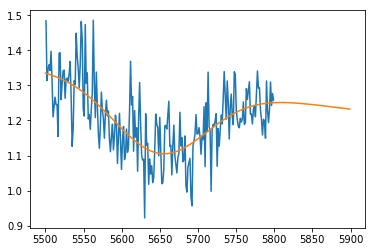

In [66]:
plt.plot(SiII_1_5972['Wavelength'], SiII_1_5972['Flux'])
plt.plot(x1_5972, y1_5972)
plt.show()

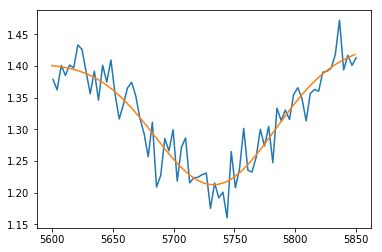

In [67]:
plt.plot(SiII_3_5972['Wavelength'], SiII_3_5972['Flux'])
plt.plot(x3_5972, y3_5972)
plt.show()

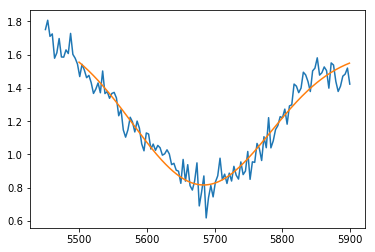

In [68]:
plt.plot(SiII_4_5972['Wavelength'], SiII_4_5972['Flux'])
plt.plot(x4_5972, y4_5972)
plt.show()

In [69]:
#Calculate Equivalent Widths
EW_1_5972 = Calc_EW(SiII_1_5972, *popt1_5972)
EW_3_5972 = Calc_EW(SiII_1_5972, *popt3_5972)
EW_4_5972 = Calc_EW(SiII_1_5972, *popt4_5972)

In [70]:
print("EW of SiII 5972 -16.5 days:    "  + str(EW_1_5972[0]) + " Angstroms")
print("EW of SiII 5972 +5.5 days:    "  + str(EW_3_5972[0]) + " Angstroms")
print("EW of SiII 5972 +13.5 days:    "  + str(EW_4_5972[0]) + " Angstroms")

EW of SiII 5972 -16.5 days:    56.64052318557707 Angstroms
EW of SiII 5972 +5.5 days:    30.6016537604874 Angstroms
EW of SiII 5972 +13.5 days:    83.24085550585485 Angstroms


In [71]:
#Calculate centroid of function
centroid_1_5972 = Calc_Centroid(SiII_1_5972, *popt1_5972)
centroid_3_5972 = Calc_Centroid(SiII_3_5972, *popt3_5972)
centroid_4_5972 = Calc_Centroid(SiII_4_5972, *popt4_5972)

SiII_restframe_5972 = 5972
#calculate absorption velocities using centroid as doppler shifted wavelength
print("Si II 5972 absorption velocity -16.5 days:   " + str(calc_abs_velc(SiII_restframe_5972, centroid_1_5972)) + " km/s")
print("Si II 5972 absorption velocity +5.5 days:   " + str(calc_abs_velc(SiII_restframe_5972, centroid_3_5972))+ " km/s")
print("Si II 5972 absorption velocity +13.5 days:   "  + str(calc_abs_velc(SiII_restframe_5972, centroid_4_5972))+ " km/s")

Si II 5972 absorption velocity -16.5 days:   16160.499290523801 km/s
Si II 5972 absorption velocity +5.5 days:   11994.536993312755 km/s
Si II 5972 absorption velocity +13.5 days:   14670.904263234586 km/s


# iPTF 16hvw spectral sequences

In [72]:
Fig1_2002bo = SN2002bo.find_spectra(-16.5)

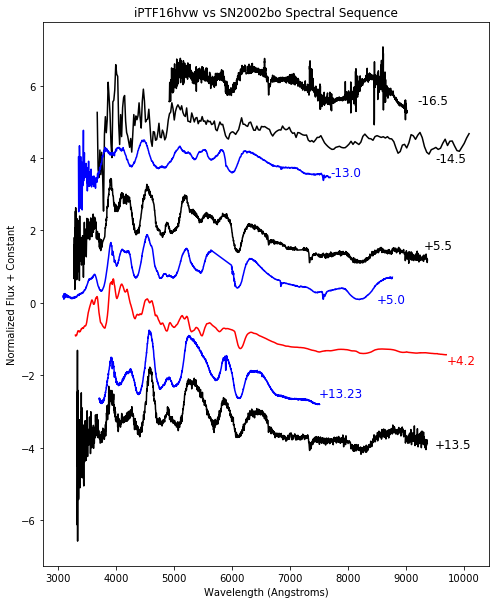

In [73]:
plt.figure(figsize=(8,10))
plt.title('iPTF16hvw vs SN2002bo Spectral Sequence')
plt.ylabel('Normalized Flux + Constant')
plt.xlabel('Wavelength (Angstroms)')

#iPTF16hvw

#plot phase = -16.5
plt.plot(hvw1_wavelength, hvw1_flux + 5, color='black')
plt.text(9200, 5.5, "-16.5", fontsize=12)

#plot phase = 
plt.plot(hvw2_wavelength, hvw2_flux + 4, color='black')
plt.text(9500, 3.9 , "-14.5", fontsize=12)

#plot phase = +5.5
plt.plot(hvw3_wavelength, hvw3_flux + 1 , color='black')
plt.text(9300, 1.5, "+5.5", fontsize=12)

#plot phase = +13.5
plt.plot(hvw4_wavelength, hvw4_flux - 4.2, color='black')
plt.text(9500, -4, "+13.5", fontsize=12)

#SN2002bo 

#plot phase = -13
plt.plot(Fig1_2002bo.data['Wavelength'], Fig1_2002bo.data['Flux'] + 3.2, color='blue' )
plt.text(7700, 3.5, "-13.0", fontsize=12, color='blue')

#plot phase = 5
plt.plot(Comp_2002bo1.data['Wavelength'], Comp_2002bo1.data['Flux'], color='blue')
plt.text(8500, 0, "+5.0", fontsize=12, color='blue')

#plot phase = 13
plt.plot(Comp_2002bo2.data['Wavelength'], Comp_2002bo2.data['Flux'] - 3.1, color='blue')
plt.text(7500, -2.6, "+13.23", fontsize=12, color='blue')
#SN2011fe

#plot phase = 4.2
plt.plot(Comp_2011fe1.data['Wavelength'], Comp_2011fe1.data['Flux'] - 1.5, color='red')
plt.text(9700, -1.7, "+4.2", fontsize=12, color='red')

plt.savefig('../paper/figures/figure1.pdf')

plt.show()

